# 04 Method Validation (Local)

This notebook validates **local functionality and behavior** for the four implemented methods:
- `lhs_static`
- `qbc_deep_ensemble`
- `marker_directed`
- `qbc_marker_hybrid`

Scope:
- protocol consistency checks (dataset/split/test-source)
- leakage checks (train-test IC overlap)
- baseline metric comparison
- round-level behavior diagnostics from run logs

This is a pre-HPC validation notebook (small/medium runs, fast iteration).


## 1) Setup


In [1]:
from __future__ import annotations

import json
import os
import re
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.dataset.data_contract import H5_X_KEYS, TRAIN_SPLIT, TEST_SPLIT

pd.set_option("display.max_columns", 300)
np.set_printoptions(suppress=True, precision=6)
plt.style.use("default")


In [13]:
# -----------------------------
# USER CONFIGURATION
# -----------------------------

DATASET_DIR = PROJECT_ROOT / "data"
MODEL_FLAG = "SM4"

# Map method -> dataset version number in data/{MODEL_FLAG}/dataset_vN
DATASET_MAP = {
    "qbc": 1,
    "lhs": 2,
    "marker": 3,
    # set when available, e.g. 6
    "hybrid": 4,
}

# Baseline metrics paths (optional)
BASELINE_METRICS = {
    "qbc": PROJECT_ROOT / "outputs/baseline/qbc_equal_s01/metrics.json",
    "lhs": PROJECT_ROOT / "outputs/baseline/lhs_equal_s01/metrics.json",
    "marker": PROJECT_ROOT / "outputs/baseline/marker_equal_s01/metrics.json",
    "hybrid": PROJECT_ROOT / "outputs/baseline/hybrid_equal_s01/metrics.json",
}

# Optional run dirs with history.jsonl + rounds/ for round-level diagnostics.
# Put paths if available; set None if not.
RUN_DIRS = {
    "qbc": None,
    "marker": None,
    "hybrid": None,
}


## 2) Helper Functions


In [14]:
def dataset_root(dataset_number: int) -> Path:
    return DATASET_DIR / MODEL_FLAG / f"dataset_v{int(dataset_number)}"


def read_info_map(info_path: Path) -> dict[str, str]:
    if not info_path.exists():
        raise FileNotFoundError(f"info.txt not found: {info_path}")
    out = {}
    for line in info_path.read_text(encoding="utf-8").splitlines():
        if ":" not in line:
            continue
        k, v = line.split(":", 1)
        out[k.strip()] = v.strip()
    return out


def list_dataset_versions() -> list[int]:
    model_dir = DATASET_DIR / MODEL_FLAG
    if not model_dir.exists():
        return []
    versions = []
    for p in model_dir.glob("dataset_v*"):
        s = p.name.replace("dataset_v", "")
        if s.isdigit():
            versions.append(int(s))
    return sorted(versions)


def _extract_ic_rows_from_h5_x_rows(x_rows: np.ndarray) -> np.ndarray:
    t = x_rows[:, 0]
    resets = np.where(t[1:] <= t[:-1])[0] + 1
    bounds = np.concatenate(([0], resets, [len(t)]))
    ics = []
    for a, b in zip(bounds[:-1], bounds[1:]):
        ics.append(x_rows[a, 1:])
    return np.stack(ics, axis=0)


def load_ic_set_from_split(ds_num: int, split: str, decimals: int = 8) -> set[tuple[float, ...]]:
    split_dir = dataset_root(ds_num) / split
    if not split_dir.exists():
        return set()

    keys = set()
    for fn in sorted(os.listdir(split_dir)):
        if not fn.endswith(".h5"):
            continue
        if "_data" not in fn or "_col" in fn or "_init" in fn:
            continue
        with h5py.File(split_dir / fn, "r") as h5f:
            x_rows = np.asarray(h5f[H5_X_KEYS[split]], dtype=np.float32)
        ics = _extract_ic_rows_from_h5_x_rows(x_rows)
        for row in ics:
            keys.add(tuple(np.round(row, decimals=decimals).tolist()))
    return keys


def nearest_distance_stats(train_set: np.ndarray, test_set: np.ndarray) -> dict[str, float]:
    # O(N*M) brute-force for local checks; fine for moderate sizes.
    d = np.linalg.norm(test_set[:, None, :] - train_set[None, :, :], axis=2)
    mins = np.min(d, axis=1)
    return {
        "min": float(np.min(mins)),
        "median": float(np.median(mins)),
        "p95": float(np.quantile(mins, 0.95)),
        "count_le_1e-8": int(np.sum(mins <= 1e-8)),
        "count_le_1e-6": int(np.sum(mins <= 1e-6)),
        "count_le_1e-4": int(np.sum(mins <= 1e-4)),
    }


def load_ic_matrix_from_split(ds_num: int, split: str) -> np.ndarray:
    split_dir = dataset_root(ds_num) / split
    mats = []
    if not split_dir.exists():
        return np.empty((0, 0), dtype=np.float32)
    for fn in sorted(os.listdir(split_dir)):
        if not fn.endswith(".h5"):
            continue
        if "_data" not in fn or "_col" in fn or "_init" in fn:
            continue
        with h5py.File(split_dir / fn, "r") as h5f:
            x_rows = np.asarray(h5f[H5_X_KEYS[split]], dtype=np.float32)
        mats.append(_extract_ic_rows_from_h5_x_rows(x_rows))
    if not mats:
        return np.empty((0, 0), dtype=np.float32)
    return np.concatenate(mats, axis=0)


def load_history(run_dir: Path) -> pd.DataFrame:
    hp = run_dir / "history.jsonl"
    if not hp.exists():
        raise FileNotFoundError(f"history.jsonl not found: {hp}")
    rows = []
    with hp.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows)


## 3) Dataset Inventory and Info Consistency


In [15]:
print("Available dataset versions:", list_dataset_versions())

rows = []
for method, ds_num in DATASET_MAP.items():
    if ds_num is None:
        continue
    info_path = dataset_root(ds_num) / "info.txt"
    info = read_info_map(info_path)
    rows.append(
        {
            "method": method,
            "dataset": f"dataset_v{ds_num}",
            "raw_total": int(info.get("Number of different simulated trajectories", -1)),
            "train": int(info.get("num of training trajectories", -1)),
            "val": int(info.get("num of validation trajectories", -1)),
            "test": int(info.get("num of testing trajectories", -1)),
            "split_mode": info.get("dataset test split mode", "<not preprocessed>"),
            "shared_test_number": info.get("dataset shared test number", "<none>"),
        }
    )

info_df = pd.DataFrame(rows).sort_values("method")
display(info_df)


Available dataset versions: [1, 2, 3, 4, 5]


,method,dataset,raw_total,train,val,test,split_mode,shared_test_number
3,hybrid,dataset_v4,2208,2208,0,480,shared_dataset,5
1,lhs,dataset_v2,2208,2208,0,480,shared_dataset,5
2,marker,dataset_v3,2208,2208,0,480,shared_dataset,5
0,qbc,dataset_v1,2208,2208,0,480,shared_dataset,5


## 4) Leakage Check (Train-Test IC Overlap)


In [16]:
leak_rows = []
for method, ds_num in DATASET_MAP.items():
    if ds_num is None:
        continue
    train_set = load_ic_set_from_split(ds_num, TRAIN_SPLIT)
    test_set = load_ic_set_from_split(ds_num, TEST_SPLIT)
    overlap = train_set.intersection(test_set)
    leak_rows.append(
        {
            "method": method,
            "dataset": f"dataset_v{ds_num}",
            "n_train_unique_ics": len(train_set),
            "n_test_unique_ics": len(test_set),
            "n_overlap": len(overlap),
        }
    )

leak_df = pd.DataFrame(leak_rows).sort_values("method")
display(leak_df)


,method,dataset,n_train_unique_ics,n_test_unique_ics,n_overlap
3,hybrid,dataset_v4,2208,480,0
1,lhs,dataset_v2,2208,480,0
2,marker,dataset_v3,2208,480,0
0,qbc,dataset_v1,2208,480,0


In [17]:
# Optional near-duplicate distance checks (stronger than exact-match overlap)
near_rows = []
for method, ds_num in DATASET_MAP.items():
    if ds_num is None:
        continue
    tr = load_ic_matrix_from_split(ds_num, TRAIN_SPLIT)
    te = load_ic_matrix_from_split(ds_num, TEST_SPLIT)
    if tr.size == 0 or te.size == 0:
        continue
    stats = nearest_distance_stats(train_set=tr, test_set=te)
    near_rows.append({"method": method, "dataset": f"dataset_v{ds_num}", **stats})

near_df = pd.DataFrame(near_rows).sort_values("method")
display(near_df)


,method,dataset,min,median,p95,count_le_1e-8,count_le_1e-6,count_le_1e-4
3,hybrid,dataset_v4,0.038129,0.119630,0.207733,0,0,0
1,lhs,dataset_v2,0.030392,0.103951,0.150361,0,0,0
2,marker,dataset_v3,0.037536,0.110021,0.185299,0,0,0
0,qbc,dataset_v1,0.029071,0.109731,0.167017,0,0,0


## 5) Baseline Metrics Comparison


,method,mse,rmse,n_train,n_test,dataset_number
1,lhs,0.000117,0.010818,2208,480,2
2,marker,0.000172,0.013105,2208,480,3
3,hybrid,0.000219,0.014814,2208,480,4
0,qbc,0.000247,0.015714,2208,480,1


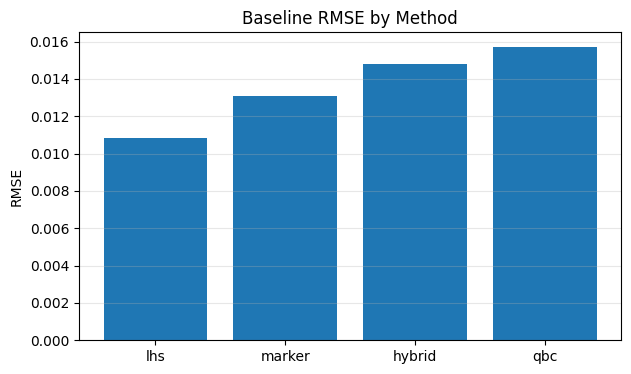

In [19]:
metric_rows = []
for method, p in BASELINE_METRICS.items():
    if p is None or not Path(p).exists():
        continue
    m = json.loads(Path(p).read_text())
    metric_rows.append(
        {
            "method": method,
            "mse": float(m.get("mse", np.nan)),
            "rmse": float(m.get("rmse", np.nan)),
            "n_train": int(m.get("n_train", -1)),
            "n_test": int(m.get("n_test", -1)),
            "dataset_number": int(m.get("dataset_number", -1)),
        }
    )

metrics_df = pd.DataFrame(metric_rows).sort_values("rmse")
display(metrics_df)

if not metrics_df.empty:
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(metrics_df["method"], metrics_df["rmse"])
    ax.set_ylabel("RMSE")
    ax.set_title("Baseline RMSE by Method")
    ax.grid(axis="y", alpha=0.3)
    plt.show()


## 6) Round-Level Diagnostics from Run Logs (Optional)


In [8]:
histories = {}
for method, rd in RUN_DIRS.items():
    if rd is None:
        continue
    rd_path = Path(rd)
    if not rd_path.exists():
        print(f"[skip] {method}: run dir not found -> {rd_path}")
        continue
    try:
        histories[method] = load_history(rd_path)
        print(f"[ok] loaded history for {method}: {len(histories[method])} rounds")
    except Exception as exc:
        print(f"[skip] {method}: {exc}")

for method, df in histories.items():
    print(f"\n--- {method} ---")
    cols = [c for c in [
        "round_idx",
        "mean_disagreement",
        "max_disagreement",
        "mean_hybrid_score",
        "mean_selected_diversity",
        "mean_selected_sparsity",
        "hybrid_marker_pca_components",
        "eval_rmse",
    ] if c in df.columns]
    display(df[cols])


In [9]:
# Plot diagnostic trends if available.
for method, df in histories.items():
    if "round_idx" not in df.columns:
        continue
    x = df["round_idx"]
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    if "mean_disagreement" in df.columns:
        axes[0].plot(x, df["mean_disagreement"], marker="o", label="mean_disagreement")
    if "mean_hybrid_score" in df.columns:
        axes[0].plot(x, df["mean_hybrid_score"], marker="o", label="mean_hybrid_score")
    axes[0].set_title(f"{method}: acquisition scores")
    axes[0].set_xlabel("round")
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    if "mean_selected_diversity" in df.columns:
        axes[1].plot(x, df["mean_selected_diversity"], marker="o", label="selected_diversity")
    if "mean_selected_sparsity" in df.columns:
        axes[1].plot(x, df["mean_selected_sparsity"], marker="o", label="selected_sparsity")
    axes[1].set_title(f"{method}: selected marker geometry")
    axes[1].set_xlabel("round")
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    fig.tight_layout()
    plt.show()


## 7) Local Validation Checklist


Use this checklist before scaling to HPC:

1. `raw_total` budget matches intended config for each method.
2. `train/test` counts are equal across compared methods.
3. `split_mode` and `shared_test_number` are identical across methods.
4. `n_overlap == 0` for train-test IC exact matches.
5. Near-duplicate train-test counts at tiny thresholds are zero.
6. Baseline metrics were trained with same model seed/hyperparameters.
7. Round histories contain expected diagnostics (QBC/hybrid/marker).
8. No NaN/inf values in stored scores or metrics.

If all pass, use the same frozen configs for HPC sweeps.
